# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from scipy.stats import f_oneway, chi2_contingency, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split


# Load Data

In [2]:
file_path = 'adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
adult_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)

# Binary indicators for capital gains and losses
adult_df['positive_capital_gain'] = (adult_df['capital-gain'] > 0).astype(int)
adult_df['positive_capital_loss'] = (adult_df['capital-loss'] > 0).astype(int)

# Interaction feature between age and education-num
adult_df['age_education_interaction'] = adult_df['age'] * adult_df['education-num']

# Aggregating less common categories into 'Other'
top_occupations = adult_df['occupation'].value_counts().nlargest(5).index
adult_df['occupation_aggregated'] = adult_df['occupation'].apply(lambda x: x if x in top_occupations else 'Other')

top_countries = adult_df['native-country'].value_counts().nlargest(5).index
adult_df['native_country_aggregated'] = adult_df['native-country'].apply(lambda x: x if x in top_countries else 'Other')

# Binning age and hours-per-week
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66+']
#adult_df['age_binned'] = pd.cut(adult_df['age'], bins=age_bins, labels=age_labels, right=False)

hours_bins = [0, 20, 30, 40, 50, 100]
hours_labels = ['0-20', '21-30', '31-40', '41-50', '51+']
#adult_df['hours_per_week_binned'] = pd.cut(adult_df['hours-per-week'], bins=hours_bins, labels=hours_labels, right=False)

adult_df = adult_df.drop(['occupation', 'native-country', 'fnlwgt'], axis=1)

# Preprocess

In [3]:
def preprocess(df, target_column=None):
    df = df.dropna()
    
    # If there's a target column, separate it out
    y = df[target_column] if target_column else None
    if target_column:
        df = df.drop(columns=[target_column])

    # Apply one-hot encoding to categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
    # Standardize numerical features
    num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])
    
    return (df_encoded, y) if target_column else df_encoded


In [4]:
def preprocess_for_arm(df, cluster_labels, target_column=None):
    """
    Preprocess data specifically for Association Rule Mining (ARM).

    Parameters:
    df (pd.DataFrame): The original DataFrame.
    cluster_labels (list or pd.Series): Cluster labels for each row in df.
    target_column (str): The name of the target column to exclude from preprocessing, if any.

    Returns:
    pd.DataFrame: DataFrame ready for ARM, including cluster labels and preprocessed features.
    """
    df = df.copy()  # Work on a copy to avoid modifying the original dataframe
    df = df.dropna()
    
    # Add cluster labels to the DataFrame before identifying categorical columns
    df['Cluster'] = cluster_labels

    if target_column:
        y = df[target_column]
        df = df.drop(columns=[target_column])

    # Identify categorical columns excluding 'Cluster'
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if 'Cluster' in cat_cols:
        cat_cols.remove('Cluster')  # Ensure the 'Cluster' column is not encoded

    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Identify numerical columns and bin them
    num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for col in num_cols:
        # Use qcut to bin data into quartiles, handling ties with 'drop' option
        df_encoded[col] = pd.qcut(df_encoded[col], q=4, duplicates='drop').astype(str)

    # One-hot encode the newly binned numerical columns
    df_encoded = pd.get_dummies(df_encoded, columns=num_cols, drop_first=True)
    df_encoded['Cluster'] = cluster_labels
    return df_encoded


# Feature Selection

In [5]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif

def feature_selection_filter_methods(df, target_column):
    """
    Perform feature selection using filter methods and low variance filtering.

    Parameters:
    df (DataFrame): The DataFrame to process.
    target_column (str): The name of the target column.
    
    Returns:
    DataFrame: The DataFrame with selected features.
    """
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Remove low variance features
    threshold = 0.01  # Threshold for variance
    sel_variance_threshold = VarianceThreshold(threshold)
    X_variance = sel_variance_threshold.fit_transform(X)
    print(f"Features retained by Variance Threshold: {X.columns[sel_variance_threshold.get_support()]}")
    
    # Select features based on chi-squared test
    # Note: Ensure the input is non-negative, chi2 is only applicable for classification tasks
    X_chi2 = SelectKBest(chi2, k=10).fit_transform(X_variance, y)
    
    # Select features based on mutual information
    X_mutual_info = SelectKBest(mutual_info_classif, k=10).fit_transform(X_variance, y)
    
    # Convert back to DataFrame for usability
    retained_features_chi2 = X.columns[SelectKBest(chi2, k=10).fit(X_variance, y).get_support()]
    retained_features_mi = X.columns[SelectKBest(mutual_info_classif, k=10).fit(X_variance, y).get_support()]
    print(f"Features retained by Chi-Squared: {retained_features_chi2}")
    print(f"Features retained by Mutual Information: {retained_features_mi}")

    # Returning X transformed for demonstration, normally you might choose one method
    return pd.DataFrame(X_chi2, columns=retained_features_chi2), pd.DataFrame(X_mutual_info, columns=retained_features_mi)

# Clustering

### Detect Knee Point

In [6]:
def plot_k_distance(data, k):
    """
    Plot the k-distance graph for the dataset to find the optimal epsilon (elbow method).
    """
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    
    # Sort distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.title("K-Distance Graph")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"Distance to {k}-th nearest neighbor")
    plt.grid(True)
    plt.show()

    return sorted_distances


In [7]:
def detect_knee_point(sorted_distances):
    """
    Detect the knee point using the 'kneed' library to find the optimal epsilon.
    """
    knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='convex', direction='increasing')
    knee_point = knee_locator.knee
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.scatter(knee_point, sorted_distances[knee_point], color='red', label='Knee point')
    plt.title("K-Distance Graph with Knee Point")
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return sorted_distances[knee_point]


### DBSCAN Parameter Optimization

In [8]:
def automated_dbscan(data):
    k = 2 * data.shape[1] - 1
    sorted_distances = plot_k_distance(data, k)
    initial_epsilon = detect_knee_point(sorted_distances)
    eps_range = np.linspace(initial_epsilon, initial_epsilon * 1.2, 5)
    min_pts_range = range(4, 5, 1)
    
    best_score = -np.inf
    best_params = None
    
    for eps in eps_range:
        for min_samples in min_pts_range:
            db = DBSCAN(eps=eps, min_samples=min_samples,  n_jobs=-1)
            labels = db.fit_predict(data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            print(f"eps: {eps}, min_pts: {min_samples}, clusters: {n_clusters}")
            # Evaluate clustering only if it's valid
            if n_clusters > 1 and n_clusters < 20: 
                score = silhouette_score(data, labels)
                if score > best_score:
                    best_score = score
                    best_params = {'epsilon': eps, 'min_samples': min_samples, 'silhouette': score}
                    
                print(f"Eps: {eps:.3f}, MinPts: {min_samples}, Score: {score:.3f}")
                
    return best_params, best_score



In [9]:
def refine_clusters(data, original_labels, best_eps, best_min_samples, relax_factor=0.2):
    """
    Refine clustering results by attempting to cluster noise points with relaxed parameters.
    Returns:
    ndarray: Updated cluster labels after noise re-clustering.
    """
    # Identify noise points
    noise_data = data[original_labels == -1]
    if noise_data.empty:
        print("No noise points to refine.")
        return original_labels

    # Adjust DBSCAN parameters for noise points
    relaxed_eps = best_eps + relax_factor * best_eps
    relaxed_min_samples = max(1, int(best_min_samples - relax_factor * best_min_samples))

    # Re-cluster noise points
    db_relaxed = DBSCAN(eps=relaxed_eps, min_samples=relaxed_min_samples)
    refined_labels = db_relaxed.fit_predict(noise_data)

    # Check if any noise points have been re-clustered successfully
    if np.any(refined_labels != -1):
        # Adjust cluster labels to be unique
        refined_labels[refined_labels != -1] += (np.max(original_labels) + 1)  
        # Update only refined labels
        final_labels = original_labels.copy()
        final_labels[original_labels == -1] = refined_labels[refined_labels != -1]  
    else:
        print("No noise points were re-clustered.")
        final_labels = original_labels.copy()
    
    silhouette = silhouette_score(data, final_labels)

    return final_labels, silhouette

In [10]:
def dbscan_clustering(data, eps, min_samples):
    """
    Apply DBSCAN clustering using optimized parameters and return labels.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(data)
    return labels


### Plots

In [11]:
def visualize_clusters(data, labels):
    """
    Use t-SNE to reduce dimensions for visualization of clusters.
    """
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Cluster')
    plt.show()

In [12]:
def visualize_clusters_pca(data, labels):
    """
    Visualizes clusters by reducing dimensions with PCA and then plotting.
    
    Parameters:
        data (DataFrame): The dataset used for clustering.
        labels (array): The cluster labels.
    """
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', edgecolor='k', s=40)
    plt.title('PCA Visualization of Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()

### Statistical Analysis

In [13]:
# Descriptive Statistics by Cluster
def descriptive_stats(df, cluster_col='Cluster'):
    return df.groupby(cluster_col).describe()

# Modified Chi-Squared Test for one-hot encoded categorical variables
def chi_squared_test(df, categorical_cols, cluster_col='Cluster'):
    results = {}
    for col in categorical_cols:
        if col == cluster_col or df[col].sum() == 0:
            continue  # Skip the cluster column or columns that are all zero
        contingency_table = pd.crosstab(df[col], df[cluster_col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        results[col] = {'chi2': chi2, 'p-value': p}
    return results

In [14]:
def perform_detailed_anova(df, cluster_col='Cluster'):
    results = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove(cluster_col)  # Exclude the cluster column to avoid errors

    for col in numeric_cols:
        # Perform ANOVA
        groups = [group[col].dropna() for name, group in df.groupby(cluster_col)]
        f_val, p_val = f_oneway(*groups)
        
        # If the result is significant, perform Tukey-HSD test
        if p_val < 0.05:
            tukey = pairwise_tukeyhsd(endog=df[col], groups=df[cluster_col], alpha=0.05)
            # Format Tukey-HSD results into a readable format
            results[col] = {
                'F-value': f_val,
                'P-value': p_val,
                'Tukey-HSD': tukey.summary().as_text()
            }

    return results

# ARM

### Transaction Conversion

In [15]:
def dataframe_to_transactions(df, cluster_label='Cluster'):
    transactions = df.drop(cluster_label, axis=1).apply(lambda row: row[row == 1].index.tolist(), axis=1).tolist()
    return transactions

def dataframe_to_transactions_per_cluster(df, cluster_label='Cluster'):
    transactions_per_cluster = {}
    for cluster in df[cluster_label].unique():
        cluster_data = df[df[cluster_label] == cluster]
        transactions_per_cluster[cluster] = cluster_data.drop(cluster_label, axis=1).apply(
            lambda row: row[row == 1].index.tolist(), axis=1
        ).tolist()
    return transactions_per_cluster


### Rule Generation and Dynamic Threshold Setting


In [16]:
def calculate_coverage_for_rules(rules, transactions):
    def calculate_coverage(rule_antecedents):
        total_transactions = len(transactions)
        antecedent_count = sum(1 for transaction in transactions if rule_antecedents.issubset(set(transaction)))
        return antecedent_count / total_transactions if total_transactions > 0 else 0
    
    rules['coverage'] = rules['antecedents'].apply(lambda x: calculate_coverage(set(x)))
    return rules


In [17]:
def generate_and_filter_rules(transactions, min_support, min_confidence, min_lift, max_items):
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    
    frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    rules['total_items'] = rules['antecedents'].apply(lambda x: len(x)) + rules['consequents'].apply(lambda x: len(x))
    #rules['coverage'] = rules['antecedents'].apply(lambda x: calculate_coverage(transactions, set(x)))
    filtered_rules = rules[(rules['lift'] >= min_lift) & (rules['total_items'] <= max_items)]
    return filtered_rules

'''def mine_rules_per_cluster(transactions_per_cluster, thresholds):
    cluster_rules = {}
    for cluster, transactions in transactions_per_cluster.items():
        cluster_rules[cluster] = generate_and_filter_rules(transactions, **thresholds)
    return cluster_rules
'''


'def mine_rules_per_cluster(transactions_per_cluster, thresholds):\n    cluster_rules = {}\n    for cluster, transactions in transactions_per_cluster.items():\n        cluster_rules[cluster] = generate_and_filter_rules(transactions, **thresholds)\n    return cluster_rules\n'

In [18]:
def adjust_thresholds(rules):
    return {
        'min_support': np.percentile(rules['support'], 75),
        'min_confidence': np.percentile(rules['confidence'], 75),
        'min_lift': np.percentile(rules['lift'], 75),
        'max_items': 3
    }

In [19]:
def adjust_thresholds_per_cluster(transactions_per_cluster, percentile=75):
    thresholds = {}
    for cluster, transactions in transactions_per_cluster.items():
        if len(transactions) > 0:
            rules = generate_and_filter_rules(transactions, min_support=0.01, min_confidence=0.01, min_lift=1.0, max_items=10)
            if not rules.empty:
                thresholds[cluster] = {
                    'min_support': max(np.percentile(rules['support'], percentile), 0.01),
                    'min_confidence': max(np.percentile(rules['confidence'], percentile), 0.1),
                    'min_lift': max(np.percentile(rules['lift'], percentile), 1.0),
                    'max_items': 3
                }
            else:
                thresholds[cluster] = {'min_support': 0.01, 'min_confidence': 0.1, 'min_lift': 1.0, 'max_items': 3}
        else:
            thresholds[cluster] = {'min_support': 0.01, 'min_confidence': 0.1, 'min_lift': 1.0, 'max_items': 3}
    return thresholds

def mine_rules_with_dynamic_thresholds(transactions_per_cluster):
    cluster_rules = {}
    thresholds = adjust_thresholds_per_cluster(transactions_per_cluster)
    for cluster, transactions in transactions_per_cluster.items():
        if transactions:
            cluster_rules[cluster] = generate_and_filter_rules(transactions, **thresholds[cluster])
    return cluster_rules, thresholds

### Rule Evaluation

In [20]:
def intra_cluster_variability(rules_per_cluster):
    stats = {cluster: rules.describe() for cluster, rules in rules_per_cluster.items()}
    return stats

def compare_rule_metrics(rules_cluster, rules_whole):
    stats = {**{k: v['confidence'].describe() for k, v in rules_cluster.items()}, 'Whole Dataset': rules_whole['confidence'].describe()}
    return pd.DataFrame(stats)

def plot_rule_distribution(rules, metric='confidence'):
    sns.histplot(data=rules, x=metric, kde=True)
    plt.title('Distribution of Rule ' + metric.capitalize())
    plt.xlabel(metric.capitalize())
    plt.ylabel('Frequency')
    plt.show()

## Find rules which are present in clusters but not in global rule set
def filter_unique_rules(rules_cluster, rules_whole):
    unique_rules = {}
    for cluster, rules in rules_cluster.items():
        if not rules.empty:
            rules['rule_set'] = rules.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)
            whole_rule_set = rules_whole.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)
            unique_rules[cluster] = rules[~rules['rule_set'].isin(whole_rule_set)]
    return unique_rules

In [21]:
def convert_rules_to_sets(rules):
    """
    Convert rules DataFrame antecedents and consequents to frozensets for easy comparison.
    """
    rules['antecedent_set'] = rules['antecedents'].apply(frozenset)
    rules['consequent_set'] = rules['consequents'].apply(frozenset)
    return rules

def find_unique_rules_per_cluster(cluster_rules):
    """
    Identify rules that are unique to each cluster compared to rules from all other clusters.
    
    Parameters:
    cluster_rules (dict): Dictionary where each key is a cluster identifier and each value is a DataFrame of rules for that cluster.
    
    Returns:
    dict: A dictionary where each key is a cluster identifier and each value is a DataFrame of rules unique to that cluster.
    """
    unique_rules_dict = {}
    
    # Concatenate all rules for comparison
    all_rules = pd.concat([convert_rules_to_sets(rules) for rules in cluster_rules.values()], keys=cluster_rules.keys())
    all_rules = all_rules.reset_index().rename(columns={'level_0': 'cluster'})

    for cluster in cluster_rules:
        current_rules = all_rules[all_rules['cluster'] == cluster]
        other_rules = all_rules[all_rules['cluster'] != cluster]

        # Perform the comparison to find unique rules
        is_unique = ~current_rules[['antecedent_set', 'consequent_set']].apply(tuple, 1).isin(
            other_rules[['antecedent_set', 'consequent_set']].apply(tuple, 1))

        unique_rules = current_rules[is_unique]
        unique_rules_dict[cluster] = unique_rules.drop(columns=['antecedent_set', 'consequent_set', 'cluster'])

    return unique_rules_dict


In [22]:
def visualize_rule_metrics(rules, metric1='coverage', metric2='lift'):
    """
    Visualize rule metrics to explore the relationship between confidence and lift.
    """
    plt.figure(figsize=(10, 5))
    plt.scatter(rules[metric1], rules[metric2], alpha=0.5)
    plt.title('Rule Metrics: Coverage vs Lift')
    plt.xlabel('Confidence')
    plt.ylabel('Lift')
    plt.grid(True)
    plt.show()

In [23]:
def plot_metrics_for_clusters(rules_cluster, dataset_name):
    # Create a single DataFrame to hold all the data for plotting
    plot_data = pd.DataFrame()

    # Loop over each cluster in the dictionary
    for cluster_id, rules in rules_cluster.items():
        # Extract the necessary data for plotting
        if 'support' in rules.columns and 'confidence' in rules.columns and 'lift' in rules.columns and 'coverage' in rules.columns:
            temp_df = rules[['support', 'confidence', 'lift', 'coverage']].copy()
            temp_df['Cluster'] = f'Cluster {cluster_id}'  # Assign cluster label for plotting
            plot_data = pd.concat([plot_data, temp_df], axis=0)

    # Create the plots
    metrics = ['support', 'confidence', 'lift', 'coverage']
    plt.figure(figsize=(18, 6))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        sns.boxplot(x='Cluster', y=metric, data=plot_data)
        plt.title(f'{metric.capitalize()} across Clusters in {dataset_name} Dataset')

    plt.tight_layout()
    plt.show()

In [24]:
def compare_common_rules_with_global(rules_cluster, global_rules):
    # Filter out the noise cluster with ID -1 if present and add global rules as cluster 'X'
    filtered_clusters = {k: v for k, v in rules_cluster.items() if k != -1}
    filtered_clusters['X'] = global_rules  # Assign global rules to cluster 'X'
    clusters = list(filtered_clusters.keys())
    common_rules_list = []

    # Iterate through each pair of clusters to find common rules
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            cluster1 = clusters[i]
            cluster2 = clusters[j]
            cluster1_rules = filtered_clusters[cluster1]
            cluster2_rules = filtered_clusters[cluster2]

            # Convert antecedents and consequents to frozensets for comparison
            cluster1_rules['rule_set'] = cluster1_rules.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)
            cluster2_rules['rule_set'] = cluster2_rules.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)

            # Find common rules between the two clusters
            common_rules = pd.merge(
                cluster1_rules, cluster2_rules, on='rule_set', suffixes=('_1', '_2')
            )

            # Calculate absolute differences in confidence and coverage
            common_rules['abs_difference_confidence'] = abs(common_rules['confidence_1'] - common_rules['confidence_2'])
            common_rules['abs_coverage_difference'] = abs(common_rules['coverage_1'] - common_rules['coverage_2'])

            # Append relevant information to the list
            for index, row in common_rules.iterrows():
                common_rules_list.append({
                    'cluster1_id': cluster1,
                    'cluster2_id': cluster2,
                    'rule': row['rule_set'],
                    'confidence_1': row['confidence_1'],
                    'confidence_2': row['confidence_2'],
                    'abs_difference_confidence': row['abs_difference_confidence'],
                    'abs_coverage_difference': row['abs_coverage_difference']
                })

    # Create DataFrame from the list of common rules
    return pd.DataFrame(common_rules_list)


### Coverage Analysis

In [25]:
def compare_coverage_between_clusters(global_rules, cluster_rules, output_path='coverage_comparison_between_clusters.csv'):
    global_rules['rule_set'] = global_rules.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)
    coverage_comparison = []

    for cluster, rules in cluster_rules.items():
        rules['rule_set'] = rules.apply(lambda x: frozenset(x['antecedents']) | frozenset(x['consequents']), axis=1)
        merged_rules = pd.merge(rules, global_rules, on='rule_set', suffixes=('_cluster', '_global'))
        for _, row in merged_rules.iterrows():
            coverage_diff = row['coverage_cluster'] - row['coverage_global']
            coverage_comparison.append({
                'Cluster': cluster,
                'Rule': frozenset(row['rule_set']),
                'Coverage Cluster': row['coverage_cluster'],
                'Coverage Global': row['coverage_global'],
                'Coverage Difference': coverage_diff
            })
    
    df = pd.DataFrame(coverage_comparison)
    df['Abs Coverage Difference'] = df['Coverage Difference'].abs()
    df_sorted = df.sort_values(by='Abs Coverage Difference', ascending=False)
    df_sorted.to_csv(output_path, index=False)
    return df_sorted

def compare_coverage_within_clusters(cluster_rules, output_path='coverage_comparison_within_clusters.csv'):
    coverage_comparison = []
    for cluster, rules in cluster_rules.items():
        mean_coverage = rules['coverage'].mean()
        for _, row in rules.iterrows():
            coverage_diff = row['coverage'] - mean_coverage
            coverage_comparison.append({
                'Cluster': cluster,
                'Rule': frozenset(row['antecedents']) | frozenset(row['consequents']),
                'Rule Coverage': row['coverage'],
                'Cluster Mean Coverage': mean_coverage,
                'Coverage Difference from Mean': coverage_diff
            })
    
    df = pd.DataFrame(coverage_comparison)
    df['Abs Coverage Difference'] = df['Coverage Difference from Mean'].abs()
    df_sorted = df.sort_values(by='Abs Coverage Difference', ascending=False)
    df_sorted.to_csv(output_path, index=False)
    return df_sorted


### Statistical Analysis

In [26]:
def compare_rules(cluster_rules, global_rules):
    comparison_results = {}
    for cluster, rules in cluster_rules.items():
        metrics = {'support': [], 'confidence': [], 'lift': []}
        for metric in metrics.keys():
            cluster_metric = rules[metric]
            global_metric = global_rules[metric]
            u_stat, p_value = mannwhitneyu(cluster_metric, global_metric, alternative='two-sided')
            metrics[metric] = {'U Statistic': u_stat, 'P-Value': p_value}
        comparison_results[cluster] = metrics
    return comparison_results

# Adult

### Clustering

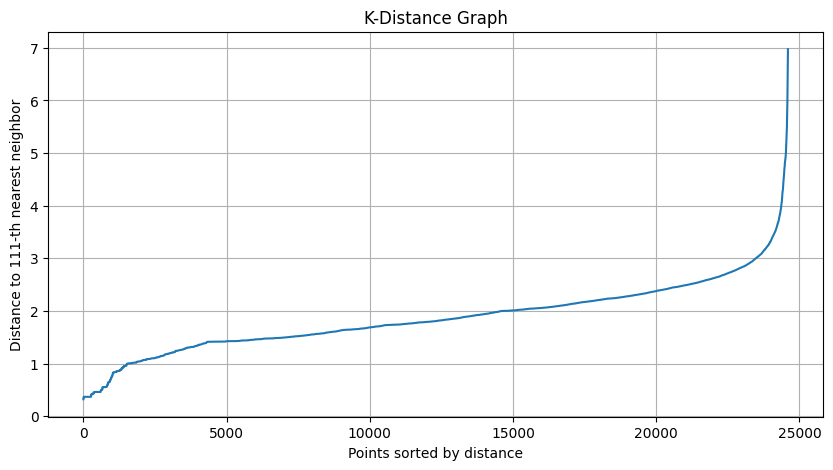

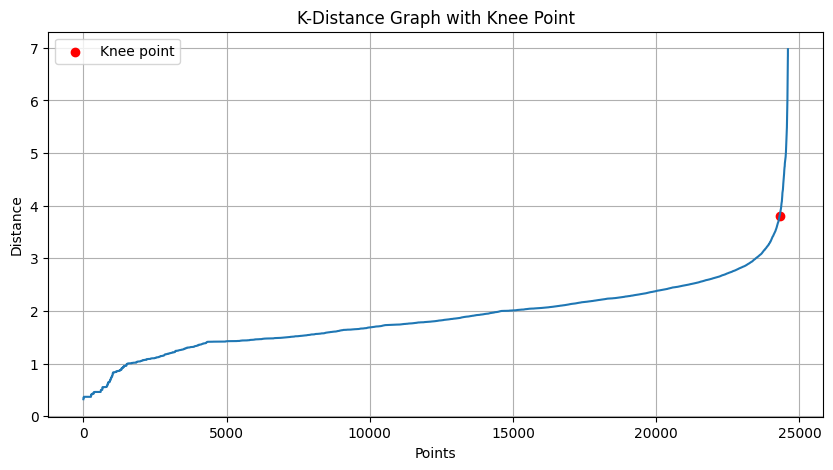

eps: 3.8040859170159296, min_pts: 4, clusters: 3
Eps: 3.804, MinPts: 4, Score: 0.488
eps: 3.994290212866726, min_pts: 4, clusters: 3
Eps: 3.994, MinPts: 4, Score: 0.488
eps: 4.184494508717522, min_pts: 4, clusters: 3
Eps: 4.184, MinPts: 4, Score: 0.479
eps: 4.374698804568318, min_pts: 4, clusters: 3
Eps: 4.375, MinPts: 4, Score: 0.479
eps: 4.564903100419115, min_pts: 4, clusters: 3
Eps: 4.565, MinPts: 4, Score: 0.479
Best Parameters: ({'epsilon': 3.8040859170159296, 'min_samples': 4, 'silhouette': 0.4880201859408698}, 0.4880201859408698)


In [27]:
#reduced_adult = feature_selection_cv(adult_df, 'income')
adult_train, adult_test = train_test_split(adult_df, test_size=0.20, random_state=42)  # 80% training and 20% testing
adult, y = preprocess(adult_train, 'income')
best_params = automated_dbscan(adult)
print("Best Parameters:", best_params)

No noise points were re-clustered.


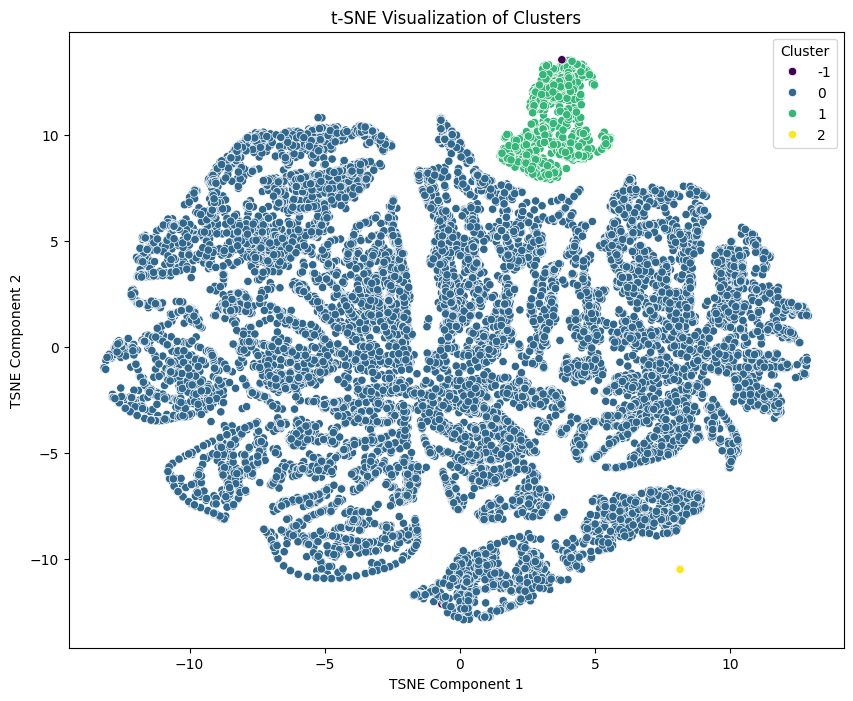

In [28]:
initial_adult_labels = dbscan_clustering(adult, best_params[0]['epsilon'], best_params[0]['min_samples'])
adult_labels, adult_train_silhouette = refine_clusters(adult, initial_adult_labels, best_params[0]['epsilon'], best_params[0]['min_samples'])
visualize_clusters(adult, adult_labels)

In [29]:
adult_test, y = preprocess(adult_test, 'income')
adult_test_labels = dbscan_clustering(adult_test, best_params[0]['epsilon'], best_params[0]['min_samples'])
adult_test_silhouette = silhouette_score(adult_test, adult_test_labels)
print("Difference in Silhouette Scores:", abs(adult_train_silhouette - adult_test_silhouette))


Difference in Silhouette Scores: 0.009963963216486182


In [30]:
adult['Cluster'] = adult_labels
anova_results = perform_detailed_anova(adult, 'Cluster')

# Print each result
for var, result in anova_results.items():
    print(f"Results for {var}:")
    print(f"F-value: {result['F-value']}")
    print(f"P-value: {result['P-value']}")
    print("Tukey-HSD Test Results:")
    print(result['Tukey-HSD'])
    print("\n")


Results for age:
F-value: 38.49415143097726
P-value: 8.27740668395873e-25
Tukey-HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    -1      0  -0.9337  0.548 -2.7463  0.879  False
    -1      1  -0.6836 0.7676 -2.4977 1.1306  False
    -1      2  -0.3153  0.971 -2.1433 1.5128  False
     0      1   0.2501    0.0  0.1737 0.3265   True
     0      2   0.6184    0.0  0.3808  0.856   True
     1      2   0.3683 0.0008  0.1199 0.6167   True
---------------------------------------------------


Results for education-num:
F-value: 106.42103835268655
P-value: 1.8687247919171227e-68
Tukey-HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    -1      0   0.6124 0.8196 -1.1928 2.4177  False
    -1      1   0.9881 0.4961 -0.8186 2.7948  False
    -1   

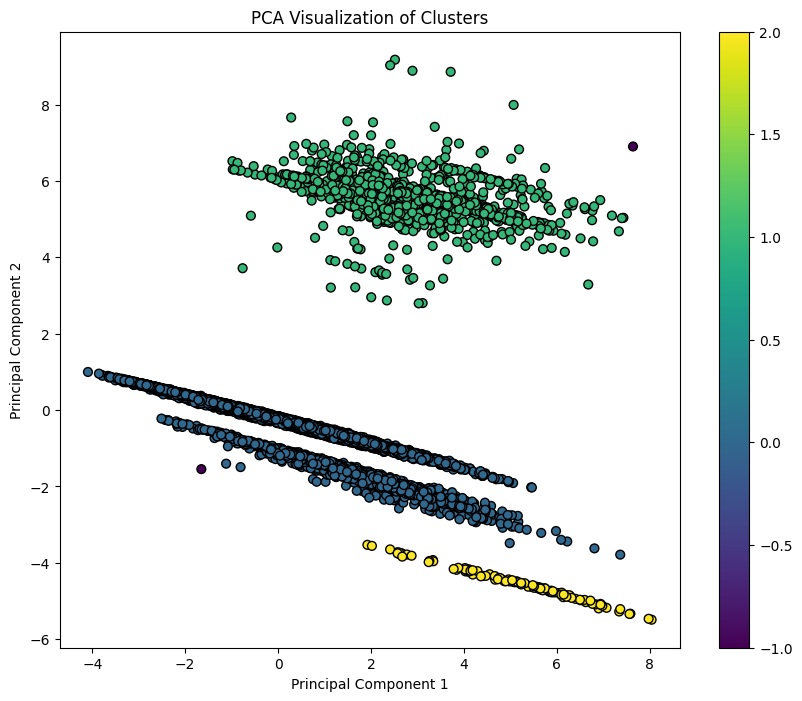

In [31]:
visualize_clusters_pca(adult, adult_labels)

In [32]:
cluster_sizes = adult.groupby('Cluster').size().to_frame()
cluster_sizes.columns = ['Cluster Size']
cluster_sizes

,Cluster Size
Cluster,
-1,2
0,23298
1,1184
2,117


In [33]:
adult_stats = descriptive_stats(adult)
adult_stats.to_csv('adult_results/adult_stats.csv')

### ARM

Preprocessing and Transaction Conversion

In [34]:
adult_arm = preprocess_for_arm(adult_train, adult_labels, 'income')

adult_transactions_whole = dataframe_to_transactions(adult_arm)
adult_transactions_cluster = dataframe_to_transactions_per_cluster(adult_arm, 'Cluster')

Rule Generation and Dynamic Threshold Setting


In [35]:
# Generate rules for the entire dataset
initial_thresholds = {'min_support': 0.1, 'min_confidence': 0.7, 'min_lift': 1.2, 'max_items': 3}
adult_rules_whole = generate_and_filter_rules(adult_transactions_whole, **initial_thresholds)

# Adjust thresholds globally based on initial rules
global_thresholds = adjust_thresholds(adult_rules_whole)

# Generate rules for each cluster
adult_rules_cluster, cluster_thresholds = mine_rules_with_dynamic_thresholds(adult_transactions_cluster)


Calculate and Add Coverage for each rule


In [36]:
adult_rules_whole = calculate_coverage_for_rules(adult_rules_whole, adult_transactions_whole)
for cluster_id, rules in adult_rules_cluster.items():
    adult_rules_cluster[cluster_id] = calculate_coverage_for_rules(rules, adult_transactions_cluster[cluster_id])

Save and Sort Rules


In [37]:
sorted_global_rules = adult_rules_whole.sort_values(by=['lift', 'confidence'], ascending=[False, False])
sorted_global_rules.to_csv('adult_results/sorted_global_rules.csv', index=False)

for cluster_id, rules in adult_rules_cluster.items():
    sorted_rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False])
    sorted_rules.to_csv(f'adult_results/sorted_rules_cluster_{cluster_id}.csv', index=False)


Rule Evaluation

In [38]:
# Analyze intra-cluster variability
cluster_variability = intra_cluster_variability(adult_rules_cluster)

# Compare rule metrics between cluster-specific and whole dataset rules
rule_metrics_comparison = compare_rule_metrics(adult_rules_cluster, adult_rules_whole)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encount

Rules Comparison

In [39]:
# Filter rules which are present in clusters but not in the global rule set
unique_rules = filter_unique_rules(adult_rules_cluster, adult_rules_whole)
# Find rules unique to each cluster
unique_cluster_rules = find_unique_rules_per_cluster(adult_rules_cluster)

In [40]:
unique_rules[0].to_csv('adult_results/unique_rules_0.csv', index=False)
unique_rules[1].to_csv('adult_results/unique_rules_1.csv', index=False)
unique_rules[2].to_csv('adult_results/unique_rules_2.csv', index=False)
unique_cluster_rules[0].to_csv('adult_results/unique_cluster_rules_0.csv', index=False)
unique_cluster_rules[1].to_csv('adult_results/unique_cluster_rules_1.csv', index=False)
unique_cluster_rules[2].to_csv('adult_results/unique_cluster_rules_2.csv', index=False)

Coverage Analysis

In [41]:
# Compare coverage between clusters and the global dataset
coverage_comparison_between_clusters = compare_coverage_between_clusters(adult_rules_whole, adult_rules_cluster, output_path='adult_results/adult_coverage_comparison_between.csv')
print(coverage_comparison_between_clusters)


# Compare coverage within each cluster
coverage_comparison_within_clusters = compare_coverage_within_clusters(adult_rules_cluster, output_path='adult_results/adult_coverage_comparison_within.csv')
print(coverage_comparison_within_clusters)


     Cluster                                               Rule  \
205       -1  (marital-status_Married-civ-spouse, sex_Male, ...   
210       -1  (marital-status_Married-civ-spouse, sex_Male, ...   
206       -1  (marital-status_Married-civ-spouse, sex_Male, ...   
207       -1  (marital-status_Married-civ-spouse, sex_Male, ...   
208       -1  (marital-status_Married-civ-spouse, sex_Male, ...   
..       ...                                                ...   
82         0  (education-num_(9.0, 10.0], sex_Male, educatio...   
83         0  (education-num_(9.0, 10.0], sex_Male, educatio...   
84         0  (education-num_(9.0, 10.0], sex_Male, educatio...   
85         0  (education-num_(9.0, 10.0], sex_Male, educatio...   
24         0  (sex_Male, education-num_(10.0, 13.0], educati...   

     Coverage Cluster  Coverage Global  Coverage Difference  \
205          0.500000         0.149344             0.350656   
210          0.500000         0.149344             0.350656   
206   

In [42]:
adult_common_rules_df = compare_common_rules_with_global(adult_rules_cluster, adult_rules_whole)
adult_common_rules_df.sort_values(by=['abs_coverage_difference'], ascending=[False]).to_csv('adult_results/adult_common_rules.csv')

Statistical Comparison

In [43]:
comparison_results = compare_rules(adult_rules_cluster, adult_rules_whole)

# Output the results
for cluster, metrics in comparison_results.items():
    print(f"Cluster {cluster}:")
    for metric, results in metrics.items():
        print(f"  {metric.capitalize()}: U Statistic = {results['U Statistic']}, P-Value = {results['P-Value']}")
    print("\n")

Cluster 0:
  Support: U Statistic = 1232.0, P-Value = 1.6411848143840786e-20
  Confidence: U Statistic = 5769.5, P-Value = 0.9382602601857009
  Lift: U Statistic = 8948.0, P-Value = 2.5511372279145463e-11


Cluster 1:
  Support: U Statistic = 772.0, P-Value = 1.0128712620555137e-24
  Confidence: U Statistic = 6006.0, P-Value = 0.6581168503576516
  Lift: U Statistic = 10746.0, P-Value = 2.1857197714107483e-24


Cluster 2:
  Support: U Statistic = 120.0, P-Value = 1.488418432100087e-20
  Confidence: U Statistic = 1890.0, P-Value = 0.4415403834668743
  Lift: U Statistic = 3911.0, P-Value = 5.418550933202662e-19


Cluster -1:
  Support: U Statistic = 55818.0, P-Value = 7.72939748611937e-208
  Confidence: U Statistic = 49173.0, P-Value = 2.455745784639898e-156
  Lift: U Statistic = 28352.0, P-Value = 0.6256948684012008




Visualizations

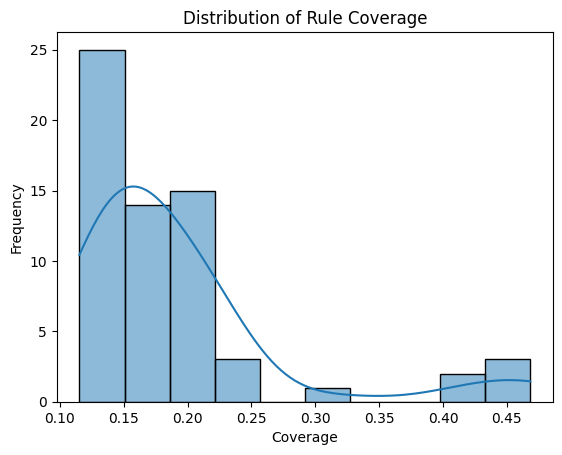

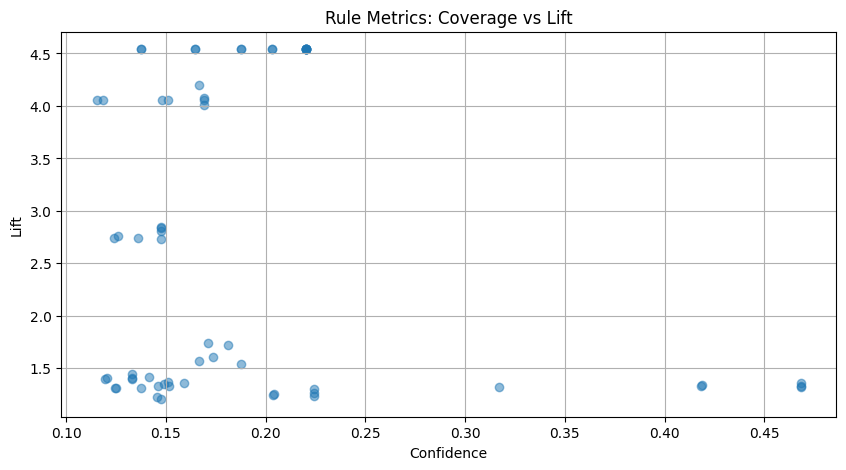

In [44]:
# Make a loop for whole and all clusters
plot_rule_distribution(adult_rules_whole, 'coverage')
visualize_rule_metrics(adult_rules_whole)

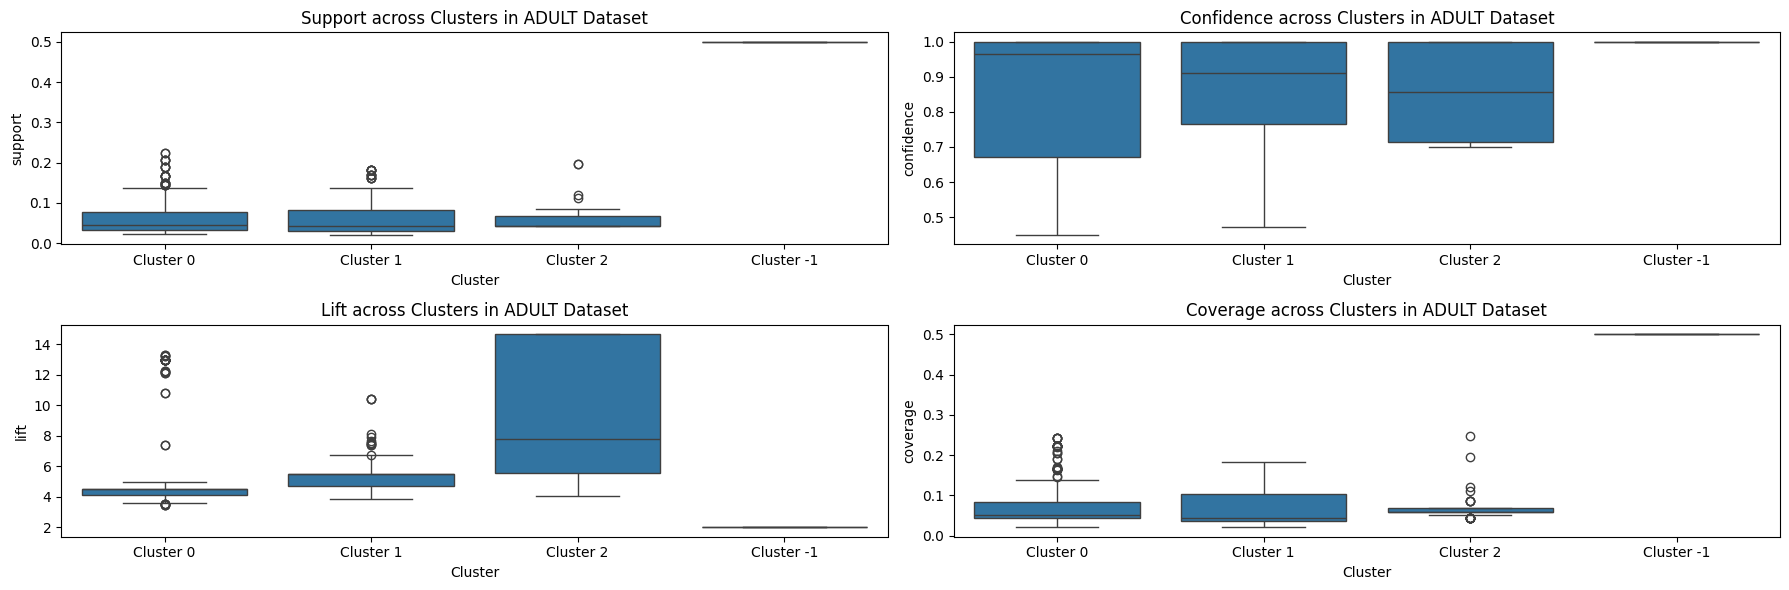

In [45]:
plot_metrics_for_clusters(adult_rules_cluster, "ADULT")

# Contraceptive Method

In [46]:
file_path = 'cmc.data'
columns = [
    'wife_age', 'wife_edu', 'husband_edu', 'num_children', 'wife_religion', 'wife_working', 'husband_occupation',
    'standard_of_living_index', 'media_exposure', 'contraceptive_method'
]
cmc_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)

cmc_df['age_children_interaction'] = cmc_df['wife_age'] * cmc_df['num_children']
cmc_df['edu_interaction'] = cmc_df['wife_edu'] * cmc_df['husband_edu']
#cmc_df['age_group'] = pd.cut(cmc_df['wife_age'], bins=[15, 24, 34, 44, 55], labels=['15-24', '25-34', '35-44', '45-55'])
cmc_df[['wife_edu', 'husband_edu', 'husband_occupation', 'standard_of_living_index']] = cmc_df[['wife_edu', 'husband_edu', 'husband_occupation', 'standard_of_living_index']].astype('category')

### Clustering

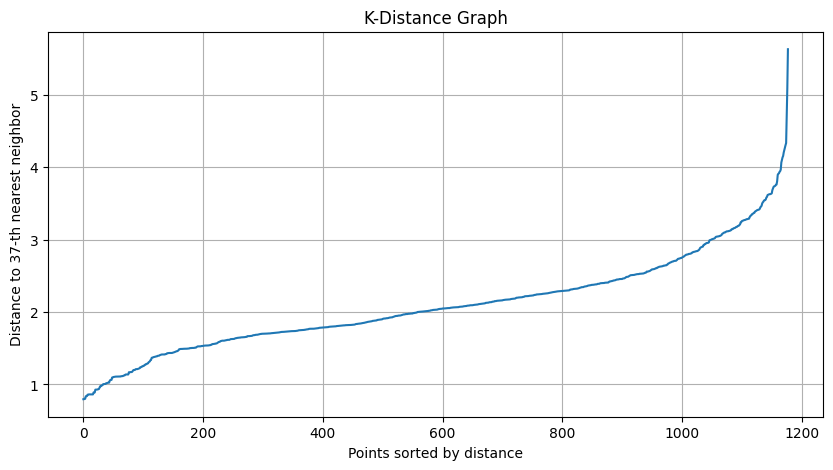

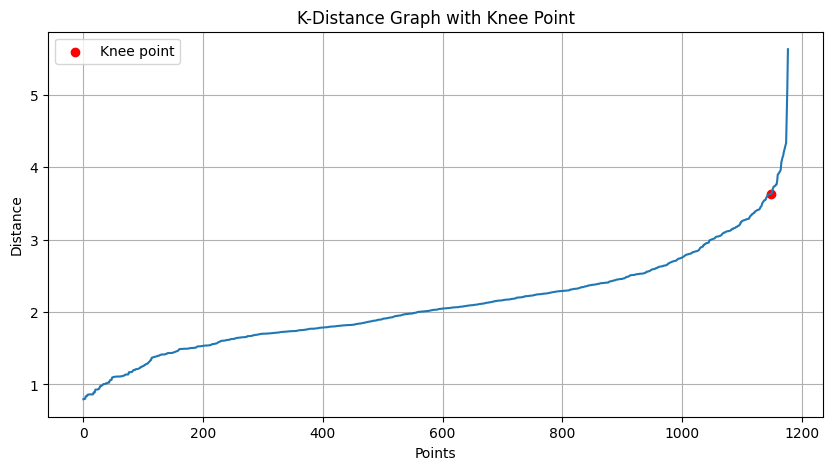

eps: 3.6292714046523606, min_pts: 4, clusters: 2
Eps: 3.629, MinPts: 4, Score: 0.317
eps: 3.8107349748849786, min_pts: 4, clusters: 1
eps: 3.9921985451175965, min_pts: 4, clusters: 1
eps: 4.173662115350215, min_pts: 4, clusters: 1
eps: 4.355125685582832, min_pts: 4, clusters: 1
Best Parameters: ({'epsilon': 3.6292714046523606, 'min_samples': 4, 'silhouette': 0.3172086854992034}, 0.3172086854992034)


In [47]:
cmc_train, cmc_test = train_test_split(cmc_df, test_size=0.20, random_state=42)  # 80% training and 20% testing
cmc, y = preprocess(cmc_train, 'contraceptive_method')
best_params = automated_dbscan(cmc)
print("Best Parameters:", best_params)

No noise points to refine.


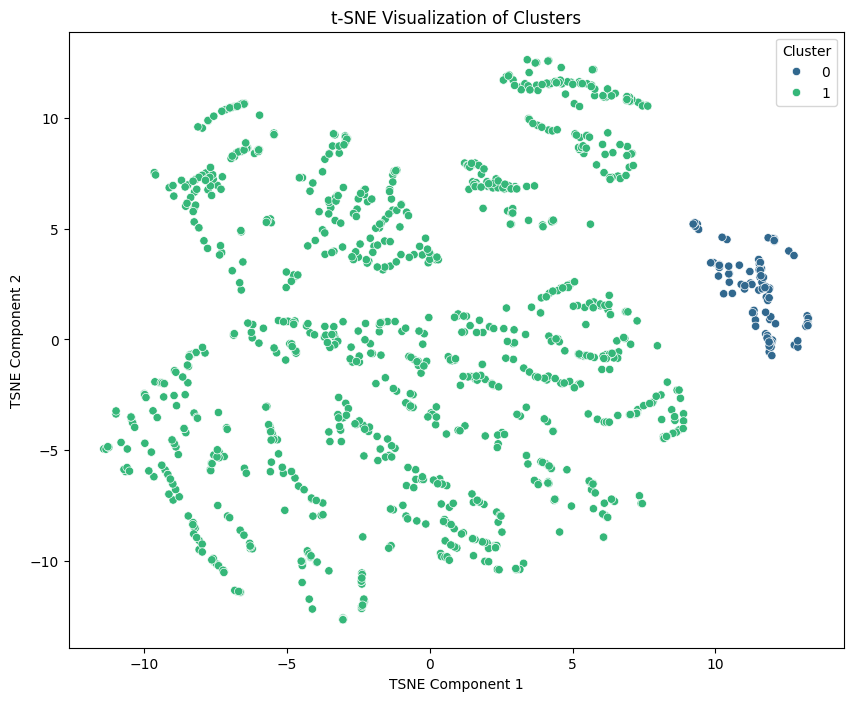

In [48]:
initial_cmc_labels = dbscan_clustering(cmc, best_params[0]['epsilon'], best_params[0]['min_samples'])
cmc_labels = refine_clusters(cmc, initial_cmc_labels, best_params[0]['epsilon'], best_params[0]['min_samples'])
cmc_train_silhouette = silhouette_score(cmc, cmc_labels)
visualize_clusters(cmc, cmc_labels)

In [49]:
cmc_test, y = preprocess(cmc_test, 'contraceptive_method')
cmc_test_labels = dbscan_clustering(cmc_test, best_params[0]['epsilon'], best_params[0]['min_samples'])
cmc_test_silhouette = silhouette_score(cmc_test, cmc_test_labels)
print("Difference in Silhouette Scores:", abs(cmc_train_silhouette - cmc_test_silhouette))


Difference in Silhouette Scores: 0.017690764410337623


In [50]:
cmc['Cluster'] = cmc_labels
anova_results = perform_detailed_anova(cmc, 'Cluster')

# Print each result
for var, result in anova_results.items():
    print(f"Results for {var}:")
    print(f"F-value: {result['F-value']}")
    print(f"P-value: {result['P-value']}")
    print("Tukey-HSD Test Results:")
    print(result['Tukey-HSD'])
    print("\n")


/var/folders/j0/85cyxkys2bs8n9q_b_twkb700000gn/T/ipykernel_38786/1566412908.py:9: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  f_val, p_val = f_oneway(*groups)


Results for wife_age:
F-value: 12.90754365945686
P-value: 0.0003407831311132134
Tukey-HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.3845 0.0003 -0.5945 -0.1745   True
----------------------------------------------------


Results for num_children:
F-value: 19.3724696854453
P-value: 1.1731443503665376e-05
Tukey-HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -0.4698   0.0 -0.6792 -0.2604   True
---------------------------------------------------


Results for wife_religion:
F-value: 5.54946515931824
P-value: 0.018649781986213025
Tukey-HSD Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------

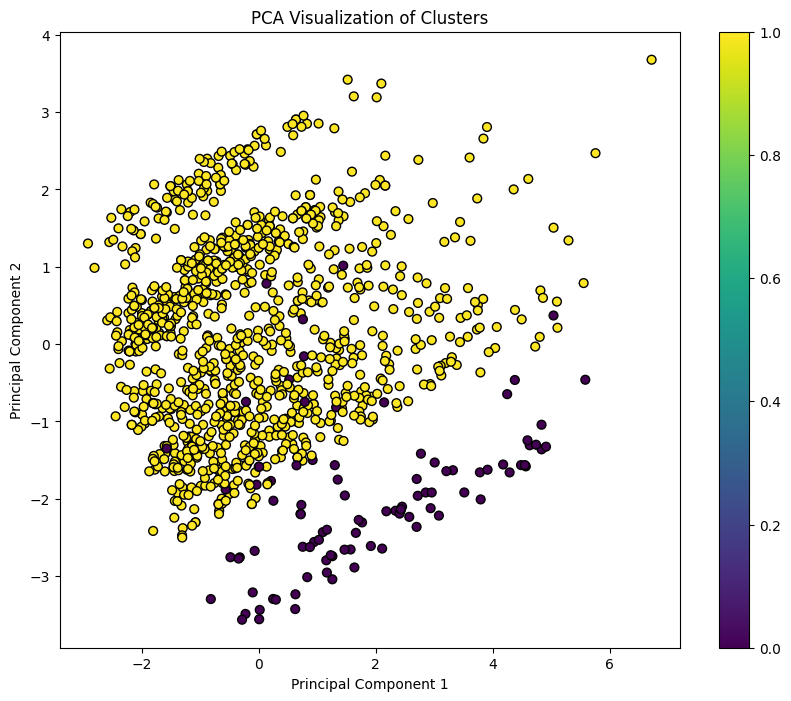

In [51]:
visualize_clusters_pca(cmc, cmc_labels)

In [52]:
cluster_sizes = cmc.groupby('Cluster').size().to_frame()
cluster_sizes.columns = ['Cluster Size']
cluster_sizes

,Cluster Size
Cluster,
0,94
1,1084


In [53]:
cmc_stats = descriptive_stats(cmc)
cmc_stats.to_csv('cmc_results/cmc_stats.csv')

### ARM

Preprocessing and Transaction Conversion

In [54]:
cmc_arm = preprocess_for_arm(cmc_train, cmc_labels, 'contraceptive_method')

cmc_transactions_whole = dataframe_to_transactions(cmc_arm)
cmc_transactions_cluster = dataframe_to_transactions_per_cluster(cmc_arm, 'Cluster')

Rule Generation and Dynamic Threshold Setting


In [55]:
# Generate rules for the entire dataset
initial_thresholds = {'min_support': 0.1, 'min_confidence': 0.7, 'min_lift': 1.2, 'max_items': 3}
cmc_rules_whole = generate_and_filter_rules(cmc_transactions_whole, **initial_thresholds)

# Adjust thresholds globally based on initial rules
global_thresholds = adjust_thresholds(cmc_rules_whole)

# Generate rules for each cluster
cmc_rules_cluster, cluster_thresholds = mine_rules_with_dynamic_thresholds(cmc_transactions_cluster)


Calculate and Add Coverage for each rule


In [56]:
cmc_rules_whole = calculate_coverage_for_rules(cmc_rules_whole, cmc_transactions_whole)
for cluster_id, rules in cmc_rules_cluster.items():
    cmc_rules_cluster[cluster_id] = calculate_coverage_for_rules(rules, cmc_transactions_cluster[cluster_id])

Save and Sort Rules


In [57]:
sorted_global_rules = cmc_rules_whole.sort_values(by=['lift', 'confidence'], ascending=[False, False])
sorted_global_rules.to_csv('cmc_results/sorted_global_rules.csv', index=False)

for cluster_id, rules in cmc_rules_cluster.items():
    sorted_rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False])
    sorted_rules.to_csv(f'cmc_results/sorted_rules_cluster_{cluster_id}.csv', index=False)


Rule Evaluation

In [58]:
# Analyze intra-cluster variability
cluster_variability = intra_cluster_variability(cmc_rules_cluster)

# Compare rule metrics between cluster-specific and whole dataset rules
rule_metrics_comparison = compare_rule_metrics(cmc_rules_cluster, cmc_rules_whole)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Rules Comparison

In [59]:
# Filter rules which are present in clusters but not in the global rule set
unique_rules = filter_unique_rules(cmc_rules_cluster, cmc_rules_whole)
# Find rules unique to each cluster
unique_cluster_rules = find_unique_rules_per_cluster(cmc_rules_cluster)

In [60]:
unique_rules[0].to_csv('cmc_results/unique_rules_0.csv', index=False)
unique_rules[1].to_csv('cmc_results/unique_rules_1.csv', index=False)
unique_cluster_rules[0].to_csv('cmc_results/unique_cluster_rules_0.csv', index=False)
unique_cluster_rules[1].to_csv('cmc_results/unique_cluster_rules_1.csv', index=False)

Coverage Analysis

In [61]:
# Compare coverage between clusters and the global dataset
coverage_comparison_between_clusters = compare_coverage_between_clusters(cmc_rules_whole, cmc_rules_cluster, output_path='cmc_results/cmc_coverage_comparison_between.csv')

# Compare coverage within each cluster
coverage_comparison_within_clusters = compare_coverage_within_clusters(cmc_rules_cluster, output_path='cmc_results/cmc_coverage_comparison_within.csv')

In [62]:
cmc_common_rules_df = compare_common_rules_with_global(cmc_rules_cluster, cmc_rules_whole)
cmc_common_rules_df.sort_values(by=['abs_coverage_difference'], ascending=[False]).to_csv('cmc_results/cmc_common_rules.csv')

Statistical Comparison

In [63]:
comparison_results = compare_rules(cmc_rules_cluster, cmc_rules_whole)

# Output the results
for cluster, metrics in comparison_results.items():
    print(f"Cluster {cluster}:")
    for metric, results in metrics.items():
        print(f"  {metric.capitalize()}: U Statistic = {results['U Statistic']}, P-Value = {results['P-Value']}")
    print("\n")

Cluster 0:
  Support: U Statistic = 0.0, P-Value = 1.465677320443674e-13
  Confidence: U Statistic = 1044.0, P-Value = 4.709102989641713e-08
  Lift: U Statistic = 1296.0, P-Value = 6.260249190321986e-15


Cluster 1:
  Support: U Statistic = 32.0, P-Value = 5.5582433878837855e-15
  Confidence: U Statistic = 597.0, P-Value = 0.00089406842102649
  Lift: U Statistic = 1988.0, P-Value = 4.454832224395789e-15




Visualizations

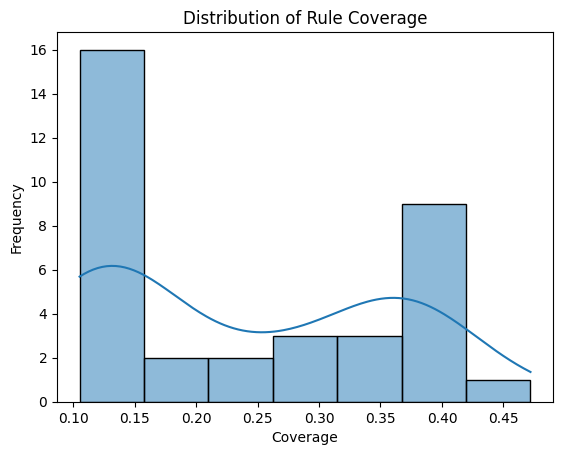

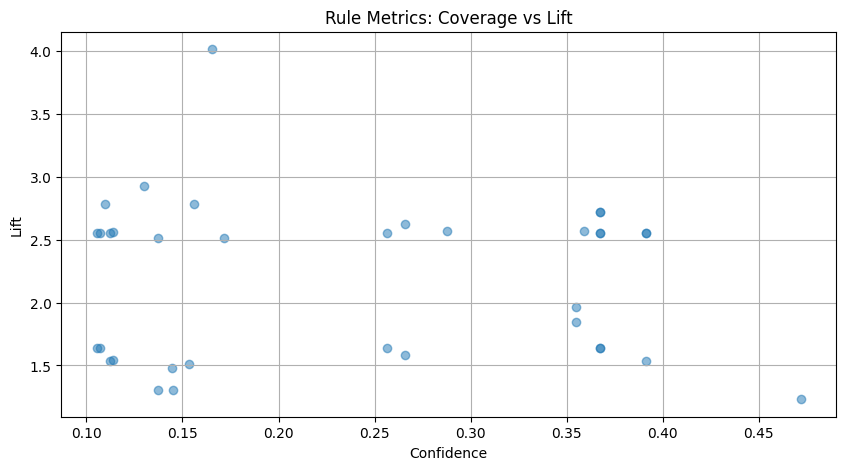

In [64]:
plot_rule_distribution(cmc_rules_whole, 'coverage')
visualize_rule_metrics(cmc_rules_whole)

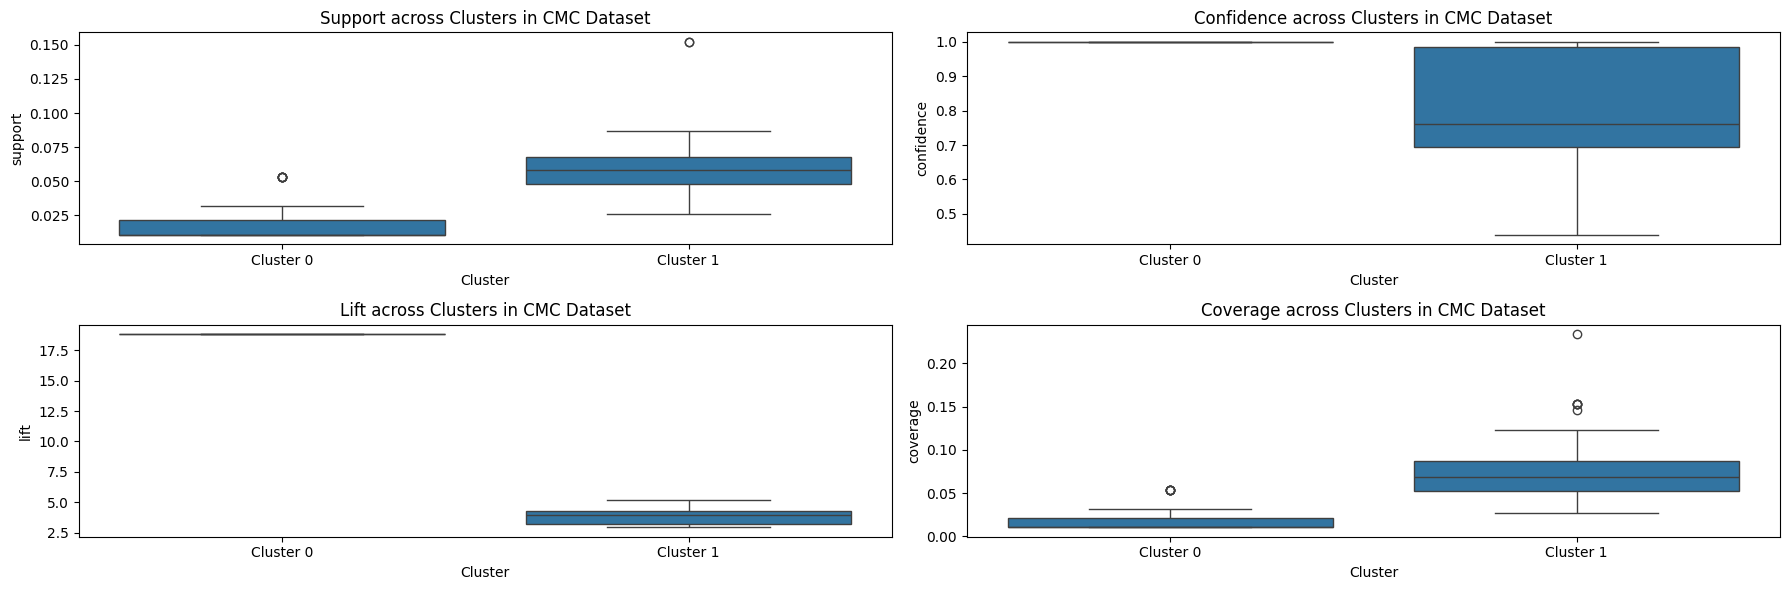

In [65]:
plot_metrics_for_clusters(cmc_rules_cluster, "CMC")